# Exercise3

Authors:
- Tuoxing Liu
- Sima Esmaeili
- Shruti Ghargi

## Task 1 Introduction

In [2]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy
from tqdm import tqdm

plt.rc("figure", dpi=100)

batch_size = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
torch.cuda.set_device(device)

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


def init_weights(shape, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape, device=device) * std
    # to make w as a leaf node (be able to calculate gradient)
    # you have to create the tensor on device
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """

    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

Device: cuda:0


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0
Mean Train Loss: 4.01e-01


  1%|          | 1/101 [00:07<13:04,  7.85s/it]

Mean Test Loss:  2.92e-01


 10%|▉         | 10/101 [00:51<07:27,  4.92s/it]

Epoch: 10
Mean Train Loss: 1.53e-01


 11%|█         | 11/101 [00:59<08:47,  5.86s/it]

Mean Test Loss:  2.56e-01


 20%|█▉        | 20/101 [01:44<06:37,  4.91s/it]

Epoch: 20
Mean Train Loss: 1.04e-01


 21%|██        | 21/101 [01:51<07:37,  5.72s/it]

Mean Test Loss:  4.32e-01


 30%|██▉       | 30/101 [02:36<05:55,  5.00s/it]

Epoch: 30
Mean Train Loss: 6.62e-02


 31%|███       | 31/101 [02:44<06:40,  5.72s/it]

Mean Test Loss:  5.46e-01


 40%|███▉      | 40/101 [03:29<05:05,  5.01s/it]

Epoch: 40
Mean Train Loss: 4.51e-02


 41%|████      | 41/101 [03:36<05:51,  5.86s/it]

Mean Test Loss:  6.84e-01


 50%|████▉     | 50/101 [04:22<04:19,  5.09s/it]

Epoch: 50
Mean Train Loss: 3.85e-02


 50%|█████     | 51/101 [04:29<04:52,  5.85s/it]

Mean Test Loss:  8.97e-01


 59%|█████▉    | 60/101 [05:16<03:33,  5.21s/it]

Epoch: 60
Mean Train Loss: 2.56e-02


 60%|██████    | 61/101 [05:26<04:28,  6.72s/it]

Mean Test Loss:  8.20e-01


 69%|██████▉   | 70/101 [06:11<02:38,  5.13s/it]

Epoch: 70
Mean Train Loss: 1.59e-02


 70%|███████   | 71/101 [06:20<03:02,  6.09s/it]

Mean Test Loss:  9.72e-01


 79%|███████▉  | 80/101 [07:08<01:51,  5.30s/it]

Epoch: 80
Mean Train Loss: 1.92e-02


 80%|████████  | 81/101 [07:15<01:59,  5.96s/it]

Mean Test Loss:  8.49e-01


 89%|████████▉ | 90/101 [08:01<00:56,  5.11s/it]

Epoch: 90
Mean Train Loss: 8.91e-03


 90%|█████████ | 91/101 [08:09<00:58,  5.89s/it]

Mean Test Loss:  8.86e-01


 99%|█████████▉| 100/101 [08:58<00:05,  5.85s/it]

Epoch: 100
Mean Train Loss: 5.90e-03


100%|██████████| 101/101 [09:07<00:00,  5.42s/it]

Mean Test Loss:  9.19e-01


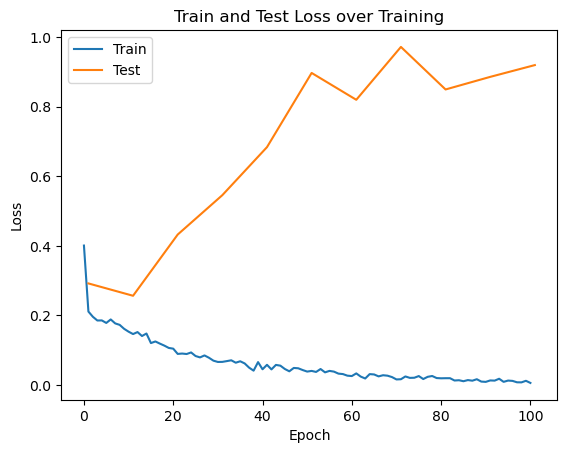

In [17]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784).to(device)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

        train_loss_this_epoch.append(float(loss.to(device)))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784).to(device)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(
                    noise_py_x, y.to(device), reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Task 2 Dropout


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0
Mean Train Loss: 1.03e+00


  1%|          | 1/101 [00:07<12:52,  7.72s/it]

Mean Test Loss:  6.63e-01


 10%|▉         | 10/101 [00:51<07:28,  4.92s/it]

Epoch: 10
Mean Train Loss: 1.02e+00


 11%|█         | 11/101 [00:59<08:34,  5.72s/it]

Mean Test Loss:  9.60e-01


 20%|█▉        | 20/101 [01:44<06:41,  4.96s/it]

Epoch: 20
Mean Train Loss: 1.27e+00


 21%|██        | 21/101 [01:52<07:38,  5.73s/it]

Mean Test Loss:  1.49e+00


 30%|██▉       | 30/101 [02:37<05:58,  5.05s/it]

Epoch: 30
Mean Train Loss: 1.55e+00


 31%|███       | 31/101 [02:44<06:44,  5.78s/it]

Mean Test Loss:  1.52e+00


 40%|███▉      | 40/101 [03:31<05:16,  5.20s/it]

Epoch: 40
Mean Train Loss: 1.72e+00


 41%|████      | 41/101 [03:38<05:56,  5.94s/it]

Mean Test Loss:  2.10e+00


 50%|████▉     | 50/101 [04:24<04:13,  4.96s/it]

Epoch: 50
Mean Train Loss: 1.91e+00


 50%|█████     | 51/101 [04:32<04:53,  5.87s/it]

Mean Test Loss:  2.09e+00


 59%|█████▉    | 60/101 [05:17<03:27,  5.05s/it]

Epoch: 60
Mean Train Loss: 1.90e+00


 60%|██████    | 61/101 [05:25<03:53,  5.84s/it]

Mean Test Loss:  2.11e+00


 69%|██████▉   | 70/101 [06:09<02:36,  5.05s/it]

Epoch: 70
Mean Train Loss: 2.09e+00


 70%|███████   | 71/101 [06:17<02:57,  5.90s/it]

Mean Test Loss:  2.86e+00


 79%|███████▉  | 80/101 [07:02<01:48,  5.17s/it]

Epoch: 80
Mean Train Loss: 2.16e+00


 80%|████████  | 81/101 [07:10<01:58,  5.94s/it]

Mean Test Loss:  2.16e+00


 89%|████████▉ | 90/101 [07:55<00:55,  5.02s/it]

Epoch: 90
Mean Train Loss: 2.18e+00


 90%|█████████ | 91/101 [08:02<00:57,  5.77s/it]

Mean Test Loss:  2.69e+00


 99%|█████████▉| 100/101 [08:47<00:04,  4.93s/it]

Epoch: 100
Mean Train Loss: 2.23e+00


100%|██████████| 101/101 [08:54<00:00,  5.29s/it]

Mean Test Loss:  2.57e+00


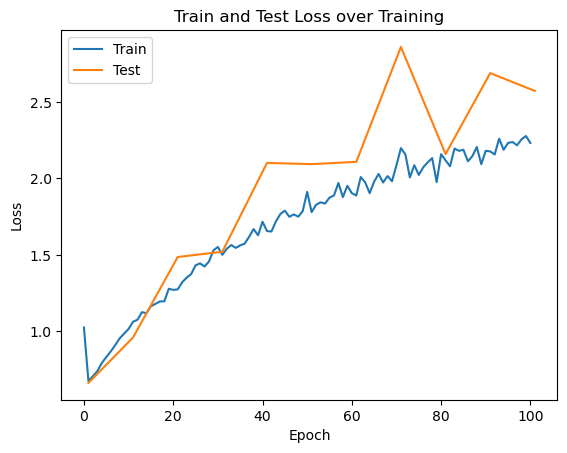

In [113]:
def dropout(X, p_drop=0.5):
    if p_drop >= 1 or p_drop <= 0:
        return X

    mask = torch.bernoulli(torch.full_like(X, 1 - p_drop))
    X_drop = X * mask / (1 - p_drop)

    return X_drop

# define the neural network
def dropout_model(x, w_h, w_h2, w_o):
    h = rectify(dropout(x) @ w_h)
    h2 = rectify(dropout(h) @ w_h2)
    pre_softmax = dropout(h2) @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784).to(device)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

        train_loss_this_epoch.append(float(loss.to(device)))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784).to(device)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o)

                loss = cross_entropy(
                    noise_py_x, y.to(device), reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Explain in a few sentences how the dropout method works and how it reduces overfitting.

The dropout method randomly set some items in the input vector to zero and compensate on the remaining items. It reduces overfitting by preventing the model from relying too heavily on specific neurons, since the neurons are randomly invalidated during training.

### Why do we need a different model configuration for evaluating the test loss? Compare the test error with the test error from Section 1.

Test error:
- Section 1: 9.19e-01
- Section 2: 2.57e+00

Though the test loss and the training loss are closer in section 2, the absolute value of test loss is much larger.

## Task 3 Parametric Relu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class PRelu(nn.Module):
    def __init__(self, num_parameters=1):
        super(PRelu, self).__init__()
        self.num_parameters = num_parameters
        self.a = nn.Parameter(torch.Tensor(num_parameters))
        self.a.data.fill_(0.25)  # Initialize with a default value of 0.25

    def forward(self, x):
        pos = torch.nn.functional.relu(x)
        neg = self.a * (x - abs(x)) * 0.5
        return pos + neg

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.prelu1 = PRelu(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.prelu1(x)
        x = self.fc2(x)
        return x

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = train_loss / len(train_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

def main():
    torch.manual_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(
        root='./data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=False)

    # Initialize the model and optimizer
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
        print()


if __name__ == '__main__':
    main()


Epoch 1/10:
Train Loss: 0.2919 | Train Accuracy: 91.43%
Test Loss: 0.1607 | Test Accuracy: 95.12%

Epoch 2/10:
Train Loss: 0.1333 | Train Accuracy: 96.06%
Test Loss: 0.1052 | Test Accuracy: 96.74%

Epoch 3/10:
Train Loss: 0.0889 | Train Accuracy: 97.35%
Test Loss: 0.0808 | Test Accuracy: 97.48%

Epoch 4/10:
Train Loss: 0.0654 | Train Accuracy: 98.03%
Test Loss: 0.0784 | Test Accuracy: 97.53%

Epoch 5/10:
Train Loss: 0.0510 | Train Accuracy: 98.48%
Test Loss: 0.0699 | Test Accuracy: 97.81%

Epoch 6/10:
Train Loss: 0.0391 | Train Accuracy: 98.82%
Test Loss: 0.0676 | Test Accuracy: 97.87%

Epoch 7/10:
Train Loss: 0.0302 | Train Accuracy: 99.12%
Test Loss: 0.0663 | Test Accuracy: 97.89%

Epoch 8/10:
Train Loss: 0.0235 | Train Accuracy: 99.40%
Test Loss: 0.0591 | Test Accuracy: 98.09%

Epoch 9/10:
Train Loss: 0.0188 | Train Accuracy: 99.52%
Test Loss: 0.0612 | Test Accuracy: 98.10%

Epoch 10/10:
Train Loss: 0.0151 | Train Accuracy: 99.64%
Test Loss: 0.0597 | Test Accuracy: 98.09%



comparison with pervious module: 

ex3 introduces the Parametric ReLU activation function, which enhances the traditional ReLU by incorporating a learnable weight vector. This allows for adaptive activation patterns and introduces additional flexibility to the model. On the other hand, ex2 implements the dropout technique, which randomly sets elements of the input to zero during training. This helps prevent overfitting by encouraging the model to learn more robust representations and reduces reliance on specific features. 

## Task 4 Convolutional layers

### 4.1 Create a Convolutional network

In [3]:
def convolutional_layer(previous_layer, weightvector, p_drop_input):
    convolutional_layer_0 = rectify(conv2d(previous_layer, weightvector))
    # reduces (2 ,2) window to 1 pixel
    subsampling_layer = max_pool2d(convolutional_layer_0, (2, 2))

    # out_layer = dropout(subsampling_layer, p_drop_input)
    out_layer = torch.nn.functional.dropout(
        subsampling_layer, p=p_drop_input, inplace=False)  # faster

    return out_layer



In [ ]:
# define the neural network
def LeNet_model(x, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o, p_drop_input=0.5, p_drop_hidden=0.5):
    h1_1 = convolutional_layer(x, w_h1_1, p_drop_input)
    h1_2 = convolutional_layer(h1_1, w_h1_2, p_drop_hidden)
    h1_3 = convolutional_layer(h1_2, w_h1_3, p_drop_hidden)

    # number_of_output_pixel is determined by previous layers
    h1_3 = torch.reshape(h1_3, (-1, 128))
    h2 = rectify(h1_3 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h1_1 = init_weights((32, 1, 5, 5))
w_h1_2 = init_weights((64, 32, 5, 5))
w_h1_3 = init_weights((128, 64, 2, 2))
# hidden layer with 625 neurons
w_h2 = init_weights((128, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h1_1, w_h1_2, w_h1_3, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        trainX, trainY = batch

        # our model requires flattened input
        # x = x.reshape(batch_size, 784)
        trainX = trainX.reshape(-1, 1, 28, 28).to(device)  # training data

        # feed input through model
        noise_py_x = LeNet_model(
            trainX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        trainY = trainY.to(device)
        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, trainY, reduction="mean")

        train_loss_this_epoch.append(float(loss.to('cpu')))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                testX, testY = batch
                testX = testX.reshape(-1, 1, 28, 28).to(device)  # test data
                noise_py_x = LeNet_model(
                    testX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o).to(device)

                testY = testY.to(device)
                loss = cross_entropy(noise_py_x, testY, reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### 4.2 Application of Convolutional network

#### 4.2.1 Draw a sketch of the network

Input layer -> convolution layer (32 features) -> subsampling layer 
-> convolution layer (64 features) -> subsampling layer 
-> convolution layer (128 features) -> subsampling layer
-> softmax output layer

#### 4.2.2 Train the model then plot

torch.Size([28, 28])


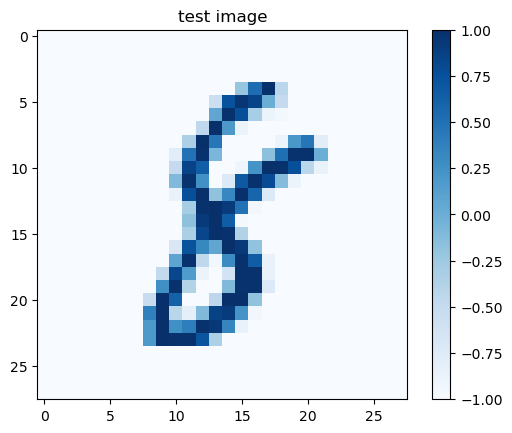

torch.Size([1, 28, 28])


In [92]:
import pickle
import math

def draw_fig(ax,data,title=""):
   # Create a color map
   cmap = plt.cm.Blues

   # Create the heatmap
   heatmap = ax.imshow(data.detach().numpy(), cmap=cmap)

   # Add a colorbar
   cbar = plt.colorbar(heatmap)

   # Set the title and labels
   ax.set_title(title)

   # Show the plot
   # plt.show()

   
with open('test_img.pickle', 'wb') as file:
    for _, batch in enumerate(test_dataloader):
            test_x, test_y = batch
    pickle.dump(test_x[0,0], file)


with open('test_img.pickle', 'rb') as file:
   test_x = pickle.load(file)
   print(test_x.shape)
   
# Create a figure and axis
fig, ax = plt.subplots()

# print(test_x)
draw_fig(ax, test_x,"test image")
plt.show()
plt.close(fig)

test_x = test_x.unsqueeze(0)
print(test_x.shape)

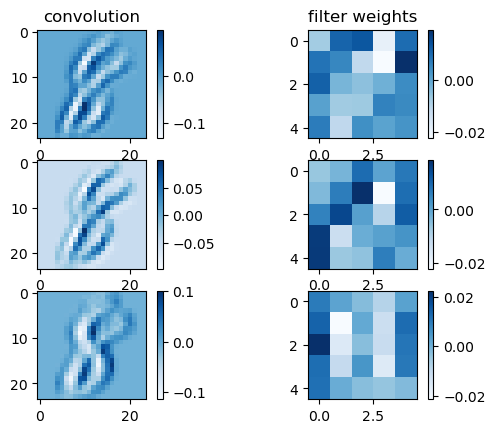

In [97]:
# with open('w1.pickle', 'wb') as file:
#     pickle.dump(w_h1_1, file)

with open('w1.pickle', 'rb') as file:
    w_h1_1 = pickle.load(file).cpu()

fig, ax = plt.subplots(3,2)


for i in range(3):
    #    print(w_h1_1[i,0])
    draw_fig(ax[i,0],conv2d(test_x ,w_h1_1[i].unsqueeze(0))[0])
    draw_fig(ax[i,1], w_h1_1[i, 0])

ax[0, 0].set_title('convolution')
ax[0, 1].set_title('filter weights')
plt.show()
plt.close(fig)

#### 4.2.3 Improve on the previous results

Here we first run a baseline of the implementation in 4.1. Then we use the adaptive learning rate to solve the problem of increasing loss.

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0
Mean Train Loss: 3.64e+00


  1%|          | 1/101 [00:07<13:13,  7.94s/it]

Mean Test Loss:  1.08e+00


 10%|▉         | 10/101 [00:56<08:14,  5.43s/it]

Epoch: 10
Mean Train Loss: 3.96e-01


 11%|█         | 11/101 [01:04<09:30,  6.33s/it]

Mean Test Loss:  3.83e-01


 20%|█▉        | 20/101 [01:55<07:40,  5.69s/it]

Epoch: 20
Mean Train Loss: 3.93e-01


 21%|██        | 21/101 [02:03<08:45,  6.57s/it]

Mean Test Loss:  3.55e-01


 30%|██▉       | 30/101 [02:55<06:44,  5.69s/it]

Epoch: 30
Mean Train Loss: 4.39e-01


 31%|███       | 31/101 [03:03<07:42,  6.60s/it]

Mean Test Loss:  4.31e-01


 40%|███▉      | 40/101 [03:54<05:48,  5.71s/it]

Epoch: 40
Mean Train Loss: 4.91e-01


 41%|████      | 41/101 [04:03<06:35,  6.59s/it]

Mean Test Loss:  4.22e-01


 50%|████▉     | 50/101 [04:58<05:19,  6.27s/it]

Epoch: 50
Mean Train Loss: 5.78e-01


 50%|█████     | 51/101 [05:07<05:58,  7.18s/it]

Mean Test Loss:  6.06e-01


 59%|█████▉    | 60/101 [06:02<04:10,  6.12s/it]

Epoch: 60
Mean Train Loss: 6.33e-01


 60%|██████    | 61/101 [06:11<04:43,  7.09s/it]

Mean Test Loss:  6.17e-01


 69%|██████▉   | 70/101 [07:04<03:03,  5.91s/it]

Epoch: 70
Mean Train Loss: 6.96e-01


 70%|███████   | 71/101 [07:13<03:23,  6.79s/it]

Mean Test Loss:  5.78e-01


 79%|███████▉  | 80/101 [08:04<02:00,  5.74s/it]

Epoch: 80
Mean Train Loss: 8.09e-01


 80%|████████  | 81/101 [08:13<02:12,  6.62s/it]

Mean Test Loss:  6.83e-01


 89%|████████▉ | 90/101 [09:04<01:02,  5.66s/it]

Epoch: 90
Mean Train Loss: 9.29e-01


 90%|█████████ | 91/101 [09:13<01:06,  6.61s/it]

Mean Test Loss:  8.31e-01


 99%|█████████▉| 100/101 [10:05<00:05,  5.82s/it]

Epoch: 100
Mean Train Loss: 1.02e+00


100%|██████████| 101/101 [10:13<00:00,  6.08s/it]

Mean Test Loss:  8.71e-01


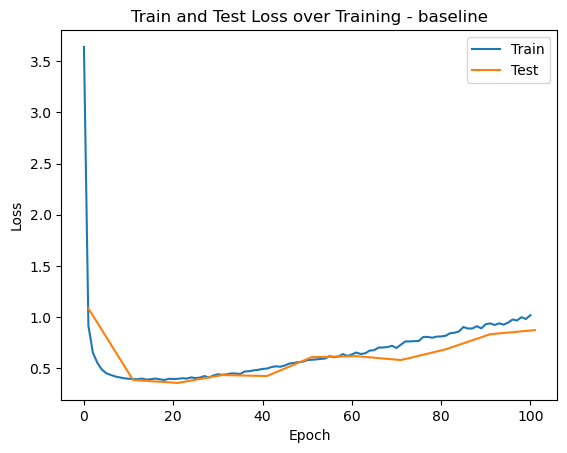

In [121]:
# initialize weights

# input shape is (B, 784)
w_h1_1 = init_weights((32, 1, 5, 5))
w_h1_2 = init_weights((64, 32, 5, 5))
w_h1_3 = init_weights((128, 64, 2, 2))
# hidden layer with 625 neurons
w_h2 = init_weights((128, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h1_1, w_h1_2, w_h1_3, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        trainX, trainY = batch

        # our model requires flattened input
        # x = x.reshape(batch_size, 784)
        trainX = trainX.reshape(-1, 1, 28, 28).to(device)  # training data

        # feed input through model
        noise_py_x = LeNet_model(
            trainX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        trainY = trainY.to(device)
        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, trainY, reduction="mean")

        train_loss_this_epoch.append(float(loss.to('cpu')))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                testX, testY = batch
                testX = testX.reshape(-1, 1, 28, 28).to(device)  # test data
                noise_py_x = LeNet_model(
                    testX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o).to(device)

                testY = testY.to(device)
                loss = cross_entropy(noise_py_x, testY, reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training - baseline")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 0
Mean Train Loss: 3.38e+00


  1%|          | 1/101 [00:07<12:55,  7.75s/it]

Mean Test Loss:  1.26e+00


 10%|▉         | 10/101 [00:56<08:18,  5.48s/it]

Epoch: 10
Mean Train Loss: 4.10e-01


 11%|█         | 11/101 [01:05<09:33,  6.37s/it]

Mean Test Loss:  3.90e-01


 20%|█▉        | 20/101 [01:55<07:45,  5.75s/it]

Epoch: 20
Mean Train Loss: 3.52e-01


 21%|██        | 21/101 [02:05<09:09,  6.86s/it]

Mean Test Loss:  3.07e-01


 30%|██▉       | 30/101 [02:57<06:59,  5.91s/it]

Epoch: 30
Mean Train Loss: 3.28e-01


 31%|███       | 31/101 [03:06<07:52,  6.76s/it]

Mean Test Loss:  3.14e-01


 40%|███▉      | 40/101 [03:58<05:52,  5.78s/it]

Epoch: 40
Mean Train Loss: 3.04e-01


 41%|████      | 41/101 [04:07<06:37,  6.63s/it]

Mean Test Loss:  2.98e-01


 50%|████▉     | 50/101 [04:58<04:52,  5.74s/it]

Epoch: 50
Mean Train Loss: 3.03e-01


 50%|█████     | 51/101 [05:07<05:32,  6.65s/it]

Mean Test Loss:  2.90e-01


 59%|█████▉    | 60/101 [05:59<03:58,  5.82s/it]

Epoch: 60
Mean Train Loss: 3.02e-01


 60%|██████    | 61/101 [06:08<04:28,  6.72s/it]

Mean Test Loss:  2.75e-01


 69%|██████▉   | 70/101 [07:00<02:59,  5.80s/it]

Epoch: 70
Mean Train Loss: 3.02e-01


 70%|███████   | 71/101 [07:09<03:19,  6.66s/it]

Mean Test Loss:  2.83e-01


 79%|███████▉  | 80/101 [08:01<02:04,  5.93s/it]

Epoch: 80
Mean Train Loss: 2.95e-01


 80%|████████  | 81/101 [08:10<02:15,  6.78s/it]

Mean Test Loss:  2.79e-01


 89%|████████▉ | 90/101 [09:01<01:02,  5.73s/it]

Epoch: 90
Mean Train Loss: 2.97e-01


 90%|█████████ | 91/101 [09:10<01:06,  6.61s/it]

Mean Test Loss:  2.69e-01


 99%|█████████▉| 100/101 [10:02<00:05,  5.84s/it]

Epoch: 100
Mean Train Loss: 2.98e-01


100%|██████████| 101/101 [10:11<00:00,  6.05s/it]

Mean Test Loss:  2.64e-01


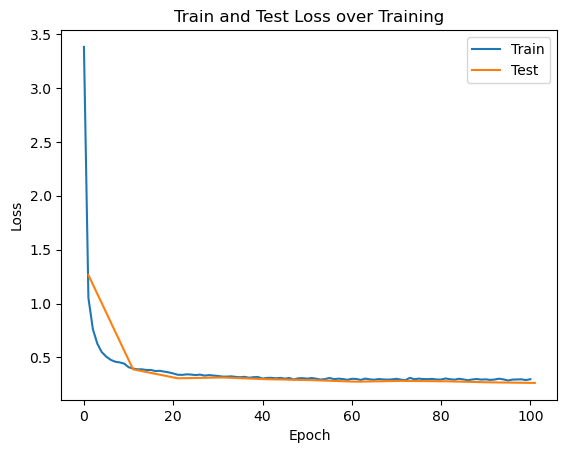

In [124]:
from torch.optim.lr_scheduler import StepLR

# initialize weights

# input shape is (B, 784)
w_h1_1 = init_weights((32, 1, 5, 5))
w_h1_2 = init_weights((64, 32, 5, 5))
w_h1_3 = init_weights((128, 64, 2, 2))
# hidden layer with 625 neurons
w_h2 = init_weights((128, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h1_1, w_h1_2, w_h1_3, w_h2, w_o])
scheduler = StepLR(optimizer,step_size=10,gamma=0.5)
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in tqdm(range(n_epochs + 1)):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        trainX, trainY = batch

        # our model requires flattened input
        # x = x.reshape(batch_size, 784)
        trainX = trainX.reshape(-1, 1, 28, 28).to(device)  # training data

        # feed input through model
        noise_py_x = LeNet_model(
            trainX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        trainY = trainY.to(device)
        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, trainY, reduction="mean")

        train_loss_this_epoch.append(float(loss.to('cpu')))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    scheduler.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                testX, testY = batch
                testX = testX.reshape(-1, 1, 28, 28).to(device)  # test data
                noise_py_x = LeNet_model(
                    testX, w_h1_1, w_h1_2, w_h1_3, w_h2, w_o).to(device)

                testY = testY.to(device)
                loss = cross_entropy(noise_py_x, testY, reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Mean Test Loss:
- Baseline: 8.71e-01
- Adaptive learning rate: 2.64e-01